# Image Colorization Using Deep Learning

# Set-Up

In [0]:
import math
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model
from tensorflow.keras.models import load_model
from tensorflow.keras.applications.vgg16 import *

import os
import cv2
from google.colab.patches import cv2_imshow

from sklearn.model_selection import train_test_split

tf.random.set_seed(42) 
np.random.seed(42)


In [65]:
print(sm.__version__)

1.0.1


In [0]:
import segmentation_models as sm

In [0]:
# !pip install segmentation-models

# from segmentation_models import Unet

# !pip install -U segmentation-models==0.2.1

# pip install git+https://github.com/qubvel/segmentation_models

sm.set_framework('tf.keras')

# Data Preparation

## Key Variables

In [0]:
IMG_SIZE     = [224, 224]
N_CHANNELS   = 3
N_CLASSES = 169
DIR_BASE = '/content/drive/My Drive/train_test/'
# PRED_DIR = '/content/drive/My Drive/prediction/'
VALID_SIZE  = 0.1765
BATCH_SIZE     = 8

## Loading Data

In [41]:
x_train = np.load(file=DIR_BASE+"x_train.npy", allow_pickle=True)
y_train = np.load(file=DIR_BASE+"y_train.npy", allow_pickle=True)
print(x_train.shape)
print(y_train.shape)

(15682, 224, 224, 3)
(15682, 224, 224)


In [42]:
x_test = np.load(file=DIR_BASE+"x_test.npy", allow_pickle=True)
y_test = np.load(file=DIR_BASE+"y_test.npy", allow_pickle=True)
print(x_test.shape)
print(y_test.shape)

(2768, 224, 224, 3)
(2768, 224, 224)


In [43]:
x_valid = np.load(file=DIR_BASE + "x_valid_new.npy", allow_pickle=True)
y_valid = np.load(file=DIR_BASE + "y_valid_new.npy", allow_pickle=True)
print(x_valid.shape)
print(y_valid.shape)

(2768, 224, 224, 3)
(2768, 224, 224)


In [0]:

class CustomDataGenerator(tf.keras.utils.Sequence):

        def __init__(self, x_set, y_set, batch_size, num_classes=N_CLASSES):
            self.x, self.y = x_set, y_set
            self.batch_size = batch_size
            self.n_classes = num_classes

        def __len__(self):
            return math.ceil(len(self.x) / self.batch_size)

        def __getitem__(self, idx):
            batch_x = self.x[idx * self.batch_size:(idx + 1) *
            self.batch_size]
            batch_y = self.y[idx * self.batch_size:(idx + 1) *
            self.batch_size]

            batch_y = tf.keras.utils.to_categorical(y=batch_y, 
                                                    num_classes=self.n_classes)
            
            return batch_x, batch_y           

In [0]:
training_generator = CustomDataGenerator(x_train, y_train, batch_size=BATCH_SIZE)
validation_generator = CustomDataGenerator(x_test, y_test, batch_size=BATCH_SIZE)
# testing_generator = CustomDataGenerator(x_test, y_test, batch_size=BATCH_SIZE)

# Model Architecture

## Model Building

In [0]:
# def FCN8(image_size, ch_in, ch_out):

#     inputs = Input(shape=(*image_size, ch_in), name='input')

#     # Building a pre-trained VGG-16 as a feature extractor
#     vgg16 = VGG16(include_top=False, weights='imagenet', input_tensor=inputs)

#     # Feature maps of final 3 blocks:
#     f3 = vgg16.get_layer('block3_pool').output  # shape: (28, 28, 256)
#     f4 = vgg16.get_layer('block4_pool').output  # shape: (14, 14, 512)
#     f5 = vgg16.get_layer('block5_pool').output  # shape: ( 7,  7, 512)

#     f5conv1 = Conv2D(filters=4086, kernel_size=7, padding='same', 
#                      activation='relu')(f5)
#     f5drop1 = Dropout(0.5)(f5conv1)
#     f5conv2 = Conv2D(filters=4086, kernel_size=1, padding='same', 
#                      activation='relu')(f5drop1)
#     f5drop2 = Dropout(0.5)(f5conv2)
#     f5conv3 = Conv2D(filters=ch_out, kernel_size=1, padding='same', 
#                      activation=None)(f5drop2)

#     # Upscale f5 into a 14x14 feature map
#     f5conv3x2 = Conv2DTranspose(filters=ch_out, kernel_size=4, strides=2, 
#                                 use_bias=False, padding='same', 
#                                 activation='relu')(f5)
#     f4conv1 = Conv2D(filters=ch_out, kernel_size=1, padding='same', 
#                      activation=None)(f4)
#     m1 = add([f4conv1, f5conv3x2])

#     m1x2 = Conv2DTranspose(filters=ch_out, kernel_size=4, strides=2, 
#                            use_bias=False, padding='same', 
#                            activation='relu')(m1)
#     f3conv1 = Conv2D(filters=ch_out, kernel_size=1, padding='same', 
#                      activation=None)(f3)
#     m2 = add([f3conv1, m1x2])

#     # Upscale the feature map to the original shape of 224x224
#     outputs = Conv2DTranspose(filters=ch_out, kernel_size=16, strides=8, 
#                               padding='same', activation='softmax')(m2)
    
#     model = Model(inputs, outputs)
#     return model

## Model Instantiation and summary

In [0]:
# model = FCN8(IMG_SIZE, N_CHANNELS, N_CLASSES)
# model.summary()

## Unet Model

In [56]:
unet_model = sm.Unet(backbone_name='mobilenetv2', encoder_weights='imagenet', 
                  classes=169, input_shape=(224,224,3), activation='softmax')
unet_model.summary()

9412608/9406464 [==============================] - 1s 0us/step
Model: "model_10"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
Conv1_pad (ZeroPadding2D)       (None, 225, 225, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 112, 112, 32) 864         Conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 112, 112, 32) 128         Conv1[0][0]                      
____________________________

In [0]:
# unet_model.compile('Adam', loss=tf.keras.losses.CategoricalCrossentropy(), metrics=[tf.metrics.MeanIoU(num_classes=169, name='mIoU')])

# history = unet_model.fit_generator(generator=training_generator,
                              # validation_data=validation_generator,
                              # epochs=1)

# Training Preparation

## Metrics and Loss

**Metrices**: Accuracy and IoU


**Loss**: cross-entropy vs. Dice


Since we are doing multi-class classification task (pixel-level classification), we can use **cross-entropy loss**. However, to prevent the model from developing bias towards larger classes, **dice loss** function will be used because it is not affected by class proportions.

In [0]:
# TODO: Dice loss

# @tf.function
def dice_loss(y_true, y_pred, eps=1e-6, spatial_axes=[1, 2], from_logits=False):
  
    num_classes = y_pred.shape[-1]
        
    # Transform logits in probabilities, and one-hot the ground-truth:
    
    # Compute Dice numerator and denominator:
    num_perclass = 2 * tf.reduce_sum(y_pred * y_true, axis=spatial_axes)
    den_perclass = tf.reduce_sum(y_pred + y_true, axis=spatial_axes)

    # Compute Dice and average over batch and classes:
    dice = tf.reduce_mean((num_perclass + eps) / (den_perclass + eps))

    return 1 - dice


class DiceLoss(tf.losses.Loss):
    def __init__(self, eps=1e-6, spatial_axes=[1, 2], from_logits=False, 
                 name='loss'):
        super().__init__(name=name)
        self.eps = eps
        self.spatial_axes = spatial_axes
        self.from_logits = from_logits
    
    def __call__(self, y_true, y_pred, sample_weight=None):
        return dice_loss(y_true, y_pred, eps=self.eps, 
                         spatial_axes=self.spatial_axes, from_logits=self.from_logits)

In [0]:
accuracy = tf.metrics.Accuracy(name='acc')
meanIoU  = tf.metrics.MeanIoU(num_classes=N_CLASSES, name='mIoU')
loss_c = tf.keras.losses.CategoricalCrossentropy()
loss_d = DiceLoss()

## Optimizer and Callbacks

In [0]:
optimizer = tf.keras.optimizers.Adam()

## Hyper Parameters

In [0]:
NUM_EPOCHS     = 1

# Training

In [0]:
unet_model.compile(optimizer=optimizer, loss=loss_d, metrics=[accuracy, meanIoU])

# model.compile(optimizer=optimizer, loss=loss_c, metrics=[accuracy, meanIoU])

In [58]:
history = unet_model.fit(x=training_generator,
                              validation_data=validation_generator,
                              epochs=NUM_EPOCHS)


# history = model.fit(x=training_generator,
                              # validation_data=validation_generator,
                              # epochs=NUM_EPOCHS)

1961/1961 [==============================] - 1289s 657ms/step - loss: 0.2067 - acc: 0.0020 - mIoU: 0.4971 - val_loss: 0.0825 - val_acc: 0.0042 - val_mIoU: 0.4970


## Graphs

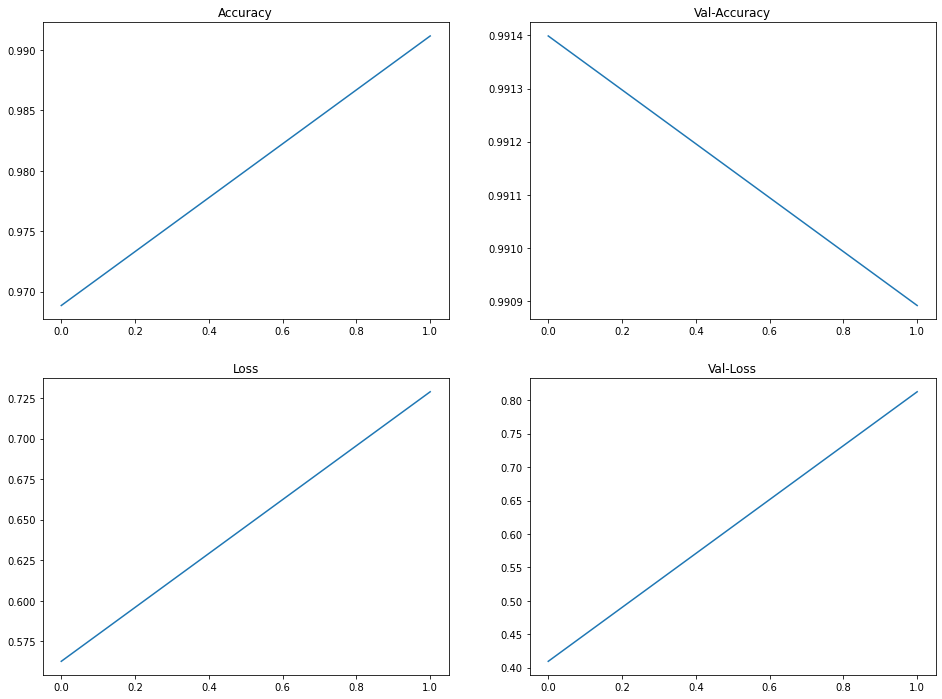

In [0]:
fig, ax = plt.subplots(2, 2, figsize=(16, 12))
ax[0, 0].set_title("Accuracy")
ax[0, 1].set_title("Val-Accuracy")
ax[1, 0].set_title("Loss")
ax[1, 1].set_title("Val-Loss")

ax[0, 0].plot(history.history['acc'])
ax[0, 1].plot(history.history['val_acc'])
ax[1, 0].plot(history.history['loss'])
ax[1, 1].plot(history.history['val_loss'])

# Testing


In [0]:
history_test = unet_model.evaluate(x=validation_generator)

1/1 [==============================] - 0s 2ms/step - loss: 0.8052 - acc: 0.9911 - mIoU: 0.5663


# Prediction

In [0]:
PRED_DIR = '/content/drive/My Drive/prediction/'

x_true = np.load(file=PRED_DIR + "x_true.npy", allow_pickle=True)

def predict(images, model):
  x_true = images
  y_pred = np.argmax(model.predict(x), axis=-1)

  return x_true, y_pred

x_pred,y_pred = predict(x_true, unet_model) 

np.save(PRED_DIR+"x_pred.npy", x_true)
np.save(PRED_DIR+"y_pred.npy", y_pred)

# Post-process Images

In [0]:
# Create Color Array
# min = 0, max = 250, interval = 20 
def create_color_array(min, max, interval):
  ab_color_list = []

  for i in range(min, max, interval):
    for j in range(min, max, interval):
      ab_color_list.append([i, j])
      j += interval
    i += interval
  
  return ab_color_list

def convert_numpy_target_array(color_array, target_numpy_array):
  target_list = target_numpy_array.tolist()
  a_list = []
  b_list = []

  for i in range(0, len(target_list)):
    new_a_list_row = []
    new_b_list_row = []
    for j in range(0, len(target_list[i])):
      a = color_array[target_list[i][j]][0]
      b = color_array[target_list[i][j]][1]
      new_a_list_row.append(a)
      new_b_list_row.append(b)
    a_list.append(new_a_list_row)
    b_list.append(new_b_list_row)
    
    # L, a, b require specific data types 'dtype=uint8'
    a_list_numpy_array = np.array(a_list, dtype=np.uint8)
    b_list_numpy_array = np.array(b_list, dtype=np.uint8)

  return (a_list_numpy_array, b_list_numpy_array)

def post_process_image(x, y_pred, ab_color_list, index):
  L = cv2.cvtColor(x, cv2.COLOR_RGB2GRAY)
  a, b = convert_numpy_target_array(ab_color_list, y_pred)
  merged_image = cv2.merge((L, a, b))
  image_bgr = cv2.cvtColor(merged_image, cv2.COLOR_LAB2BGR)
  cv2.imwrite(PRED_DIR+str(index)+'.jpg', image_bgr)


In [0]:
x = np.load(PRED_DIR+"x_pred.npy", allow_pickle=True)
y_pred = np.load(PRED_DIR+"y_pred.npy", allow_pickle=True)

ab_color_list = create_color_array(0, 260, 20)

for i in range(len(x)):
  post_process_image(x[i], y_pred[i], ab_color_list,  i)

# Misc.

In [0]:
gpu = tf.test.is_gpu_available(
    cuda_only=False, min_cuda_compute_capability=None
)

print(gpu)

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.
True


In [0]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Select the Runtime → "Change runtime type" menu to enable a GPU accelerator, ')
  print('and then re-execute this cell.')
else:
  print(gpu_info)

Wed Apr 15 12:55:33 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.64.00    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   52C    P0    33W / 250W |  10923MiB / 16280MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [0]:
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('To enable a high-RAM runtime, select the Runtime → "Change runtime type"')
  print('menu, and then select High-RAM in the Runtime shape dropdown. Then, ')
  print('re-execute this cell.')
else:
  print('You are using a high-RAM runtime!')

Your runtime has 27.4 gigabytes of available RAM

You are using a high-RAM runtime!
